In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df = pd.read_csv("/content/drive/My Drive/data/DATA/lending_club_loan_two.csv")

In [257]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
loan_amnt               396030 non-null float64
term                    396030 non-null object
int_rate                396030 non-null float64
installment             396030 non-null float64
grade                   396030 non-null object
sub_grade               396030 non-null object
emp_title               373103 non-null object
emp_length              377729 non-null object
home_ownership          396030 non-null object
annual_inc              396030 non-null float64
verification_status     396030 non-null object
issue_d                 396030 non-null object
loan_status             396030 non-null object
purpose                 396030 non-null object
title                   394275 non-null object
dti                     396030 non-null float64
earliest_cr_line        396030 non-null object
open_acc                396030 non-null float64
pub_rec                 396030 non-nu

In [259]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [0]:
# One hot encoding categorical labels in our dataset
df = pd.concat([pd.get_dummies(df[["verification_status","sub_grade","application_type","purpose"]], drop_first=True), df], axis=1) 

# "NONE" and "ANY" labels have small sample size so relabeling them to "OTHER"
df["home_ownership"].replace(["NONE","ANY"],"OTHER")
df = pd.concat([pd.get_dummies(df["home_ownership"], drop_first=True), df], axis=1)

# Extracting zip code from address label
df["address"] = df["address"].apply(lambda address:address[-5:])
df = pd.concat([df, pd.get_dummies(df["address"], drop_first=True)], axis=1)

# Converting "earliest credit line" into a year format 
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"])
df["earliest_cr_line"] = df["earliest_cr_line"].apply(lambda date:date.year) # Just need the year value
df["earliest_cr_line"].astype(int) # Converting value to integers rather than strings

In [0]:
# Columns to be dropped
df.drop(["emp_length","grade","title", "verification_status",
         "sub_grade", "application_type", "purpose","home_ownership",
         "address","emp_title","issue_d"], axis=1, inplace=True)

In [0]:
total_acc_mean = df.groupby("total_acc").mean()["mort_acc"] # Average mortage accounts per total account number

def fill_mort(total_acc,mort_acc): # Function to fill out all missing mortgage account values with the average from above dataframe
  if np.isnan(mort_acc):
    return total_acc_mean[total_acc]
  else:
    return mort_acc

df["mort_acc"] = df.apply(lambda x:fill_mort(x["total_acc"], x["mort_acc"]), axis=1)

In [0]:
df["initial_list_status"] = df["initial_list_status"].map({"w":0, "f":1})
df["loan_status"] = df["loan_status"].map({"Fully Paid": 1, "Charged Off": 0})
df["term"] = df["term"].map({" 36 months":36, " 60 months":60})
df.dropna(inplace=True) # Dropping unaccounted NAN values

In [264]:
# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Defining target and features
X = df.drop("loan_status", axis=1).values
y = df["loan_status"].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Scaling our data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Making sure dimensions are correct
print("X_train shape: {}".format(X_train.shape), "y_train shape: {}".format(y_train.shape), 
      "X_test shape: {}".format(X_test.shape), "y_test shape: {}".format(y_test.shape), sep="\n")

X_train shape: (316175, 80)
y_train shape: (316175,)
X_test shape: (79044, 80)
y_test shape: (79044,)


In [0]:
# Creating our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(78, activation="relu")) 
model.add(Dropout(0.2)) # Droupout layer added to help with overfitting

model.add(Dense(39, activation="relu")) 
model.add(Dropout(0.2))

model.add(Dense(19, activation="relu")) 
model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid")) # Output layer. This is a binary classification problem so sigmoid (logistic) activation used.

model.compile(optimizer="adam", loss="binary_crossentropy")

early_stop = EarlyStopping(patience=5, mode="min",restore_best_weights=True) # Added to avoid unnecessary training and potential overfitting

In [0]:
# Training the model
H = model.fit(X_train, y_train, batch_size=500, epochs=500, verbose=0, validation_data=(X_test,y_test), callbacks=[early_stop])

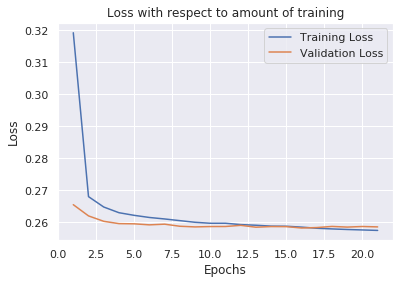

In [274]:
# Visualizing model performance
sns.set(style="darkgrid")

# Loss with respect to epochs
epochs = range(1, len(H.history["loss"])+1)
plt.plot(epochs, H.history["loss"], label="Training Loss")
plt.plot(epochs, H.history["val_loss"], label="Validation Loss")
plt.title("Loss as training progresses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [275]:
# Performance Metrics on training data
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_classes(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.99      0.44      0.61     62102
           1       0.88      1.00      0.94    254073

    accuracy                           0.89    316175
   macro avg       0.93      0.72      0.77    316175
weighted avg       0.90      0.89      0.87    316175



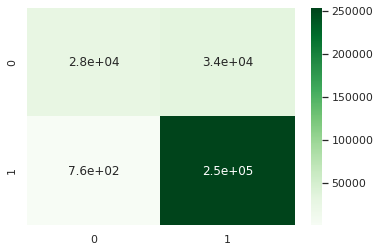

In [269]:
# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_train, predictions), annot=True, cmap="Greens")

In [270]:
# Performance Metrics on testing data
test_predictions = model.predict_classes(X_test)
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.96      0.45      0.61     15421
           1       0.88      1.00      0.94     63623

    accuracy                           0.89     79044
   macro avg       0.92      0.72      0.77     79044
weighted avg       0.90      0.89      0.87     79044



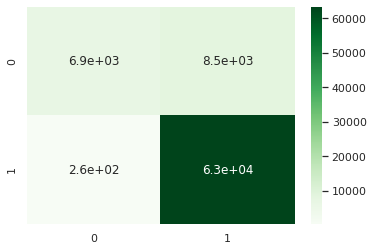

In [271]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, cmap="Greens")